In [1]:
# importing libraries
import pandas as pd
import numpy as np
import re
from tqdm import tqdm_notebook
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy import sparse
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import scipy
from sklearn.naive_bayes import MultinomialNB
from prettytable import PrettyTable

In [2]:
X_train_bow = sparse.load_npz('X_train_bow.npz')
X_test_bow = sparse.load_npz('X_test_bow.npz')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [3]:
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

(80000, 10471) (80000,)
(20000, 10471) (20000,)


{'alpha': 0.1}
0.7056354667664314


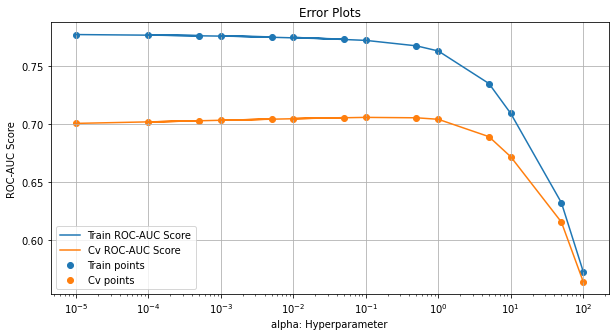

In [4]:
# using first set of features (BOW)
params_bow = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf_bow = GridSearchCV(MultinomialNB(class_prior=[0.5,0.5]), params_bow, scoring='roc_auc', cv=5, return_train_score=True)
clf_bow.fit(X_train_bow, y_train)
print(clf_bow.best_params_)
print(clf_bow.best_score_)

cv_auc_bow = clf_bow.cv_results_['mean_test_score']
train_auc_bow = clf_bow.cv_results_['mean_train_score']

plt.figure(figsize=(10,5))
plt.plot(params_bow['alpha'], train_auc_bow, label='Train ROC-AUC Score')
plt.plot(params_bow['alpha'], cv_auc_bow, label='Cv ROC-AUC Score')

plt.scatter(params_bow['alpha'], train_auc_bow, label='Train points')
plt.scatter(params_bow['alpha'], cv_auc_bow, label='Cv points')

plt.legend()
plt.xscale('log')
plt.xlabel('alpha: Hyperparameter')
plt.ylabel('ROC-AUC Score')
plt.title('Error Plots')
plt.grid()
plt.show()

Best alpha is:  0.1
Max AUC:  0.7605555811153475


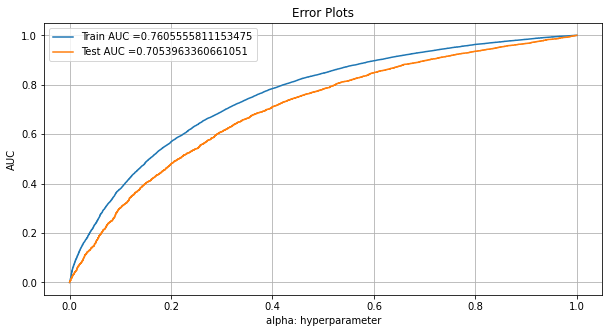

In [5]:
# best alpha is the one with maximum auc value
best_alpha_bow = clf_bow.best_params_['alpha']
print('Best alpha is: ', best_alpha_bow)

classifier_bow = MultinomialNB(alpha=best_alpha_bow, class_prior=[0.5, 0.5])
classifier_bow.fit(X_train_bow, y_train)

y_train_pred = classifier_bow.predict_proba(X_train_bow)[:,1]
y_test_pred = classifier_bow.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

auc_bow = auc(train_fpr, train_tpr)
print('Max AUC: ', str(auc_bow))

plt.figure(figsize=(10,5))
plt.plot(train_fpr, train_tpr, label='Train AUC ='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC ='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.grid()
plt.show()

In [6]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print('The maximum value of tpr*(1-fpr)', max(tpr*(1-fpr)), 'for threshold', np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [7]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)

print('Train confusion matrix:')
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print('Test confusion matrix:')
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) 0.48540404307278123 for threshold 0.456
Train confusion matrix:
[[ 8369  3725]
 [20273 47633]]
Test confusion matrix:
[[ 1858  1166]
 [ 5182 11794]]


In [8]:
# https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def plotConfusionMatrix(matrix):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Rejected','Accepted'])
    ax.yaxis.set_ticklabels(['Rejected','Accepted'])

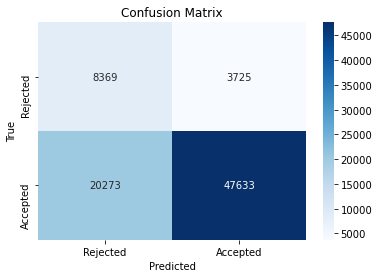

In [9]:
train_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
plotConfusionMatrix(train_matrix)

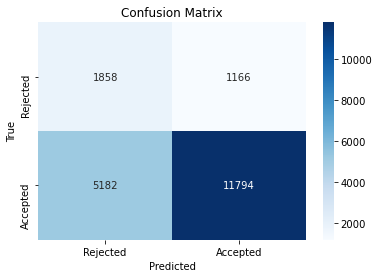

In [10]:
test_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
plotConfusionMatrix(test_matrix)

In [11]:
X_train_tfidf = sparse.load_npz('X_train_tfidf.npz')
X_test_tfidf = sparse.load_npz('X_test_tfidf.npz')

{'alpha': 1e-05}
0.6590664749521324


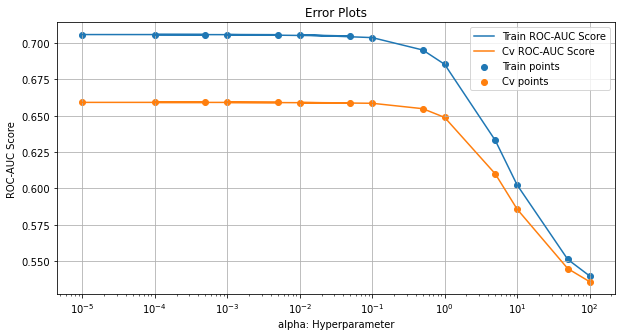

In [12]:
# using second set of features (TFIDF)
params_tfidf = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf_tfidf = GridSearchCV(MultinomialNB(class_prior=[0.5,0.5]), params_tfidf, scoring='roc_auc', cv=5, return_train_score=True)
clf_tfidf.fit(X_train_tfidf, y_train)
print(clf_tfidf.best_params_)
print(clf_tfidf.best_score_)

cv_auc_tfidf = clf_tfidf.cv_results_['mean_test_score']
train_auc_tfidf = clf_tfidf.cv_results_['mean_train_score']

plt.figure(figsize=(10,5))
plt.plot(params_tfidf['alpha'], train_auc_tfidf, label='Train ROC-AUC Score')
plt.plot(params_tfidf['alpha'], cv_auc_tfidf, label='Cv ROC-AUC Score')

plt.scatter(params_tfidf['alpha'], train_auc_tfidf, label='Train points')
plt.scatter(params_tfidf['alpha'], cv_auc_tfidf, label='Cv points')

plt.legend()
plt.xscale('log')
plt.xlabel('alpha: Hyperparameter')
plt.ylabel('ROC-AUC Score')
plt.title('Error Plots')
plt.grid()
plt.show()

Best alpha is:  1e-05
Max AUC:  0.6987292465901621


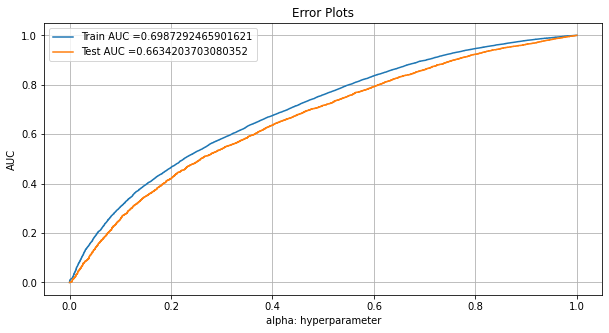

In [13]:
best_alpha_tfidf=clf_tfidf.best_params_['alpha']
print('Best alpha is: ', best_alpha_tfidf)

classifier_tfidf = MultinomialNB(alpha=best_alpha_tfidf, class_prior=[0.5, 0.5])
classifier_tfidf.fit(X_train_tfidf, y_train)

y_train_pred = classifier_tfidf.predict_proba(X_train_tfidf)[:,1]
y_test_pred = classifier_tfidf.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

auc_tfidf = auc(train_fpr, train_tpr)
print('Max AUC: ', str(auc_tfidf))

plt.figure(figsize=(10,5))
plt.plot(train_fpr, train_tpr, label='Train AUC ='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC ='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.grid()
plt.show()

In [14]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)

print('Train confusion matrix:')
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print('Test confusion matrix:')
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) 0.4108415298804745 for threshold 0.505
Train confusion matrix:
[[ 7793  4301]
 [24610 43296]]
Test confusion matrix:
[[ 1822  1202]
 [ 6207 10769]]


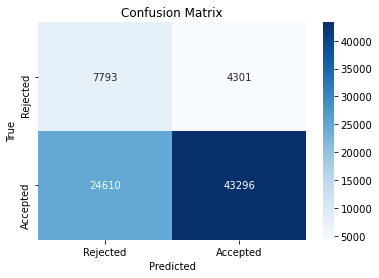

In [15]:
train_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
plotConfusionMatrix(train_matrix)

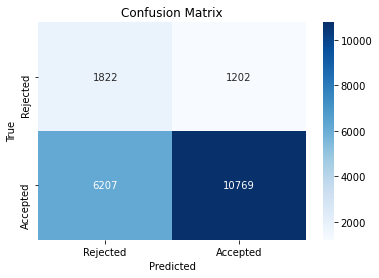

In [16]:
test_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
plotConfusionMatrix(test_matrix)

In [17]:
# summerising the results of various models
table = PrettyTable()
table.field_names = ['Vectorizer', 'Model', 'HyperParameter', 'AUC']

table.add_row(['BOW', 'Naive Bayes', best_alpha_bow, auc_bow])
table.add_row(['TFIDF', 'Naive Bayes', best_alpha_tfidf, auc_tfidf])

print(table)

+------------+-------------+----------------+--------------------+
| Vectorizer |    Model    | HyperParameter |        AUC         |
+------------+-------------+----------------+--------------------+
|    BOW     | Naive Bayes |      0.1       | 0.7605555811153475 |
|   TFIDF    | Naive Bayes |     1e-05      | 0.6987292465901621 |
+------------+-------------+----------------+--------------------+
